### experimenting with various architectures beyond MLP :-)
##############################################################
#### 1. LSTM
#### 2. CNN + LSTM
#### 3. Transformer
##############################################################
### for each of these, i'll vary: 
#### 1. num_layers
#### 2. hidden size (aka dimensionality)
#### 3. Input window length (150,300,600)... it could be that too many time-samples cause overfitting
##############################################################
#####   technically, we could do a grid search and try like 3 combos of each hyperparam, i.e. 3x3x3=27 runs for each architecture type
#####   however, i'll just run "fix and vary". it's unlikely that there are interactions here between the hyperparams


In [16]:
#libraries
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset,DataLoader
import matplotlib.pyplot as plt

#data loading
df= dataframe = pd.read_feather("combined_centroid_data.feather")
x=df["Centroid_X"].values #.values is a pd attribute #gta take .values attribute to remove all the indexing, just returns array
y=df["Centroid_Y"].values
our_data= np.stack([x,y], axis=1) #stack invents a new axis, we tryna couple the [x_i y_i]
our_data = reduced_size= our_data[:2000] #the paper didnt use all the gazilliopn timesteps, theu used 10**5 i think

In [12]:
print("heres what the dataframe looks like btw:")
print(df[:10])
print(x)
print(y)
print(our_data)
print(len(our_data))

heres what the dataframe looks like btw:
   Time (ms)  Centroid_X  Centroid_Y  Feature
0          0  -18.112448   -7.618048       39
1          1  -13.046840   -9.590575       39
2          2   -8.764083  -12.284308       39
3          3   -2.110503  -12.777150       39
4          4    1.029483  -13.182605       39
5          5    5.663209  -10.902855       39
6          6    6.456484   -9.254714       39
7          7    2.735900   -3.856508       39
8          8   -0.484103   -0.866501       39
9          9   -5.195110    3.019698       39
[-18.112448 -13.04684   -8.764083 ... -21.287073 -22.94848  -22.354143]
[ -7.618048   -9.590575  -12.284308  ...  -1.4127754  -2.2394783
  -5.196636 ]
[[-18.112448    -7.618048  ]
 [-13.04684     -9.590575  ]
 [ -8.764083   -12.284308  ]
 ...
 [ 12.165915    -2.2464797 ]
 [  9.042353    -0.05032654]
 [  9.042353     0.61739504]]
2000


In [13]:
#hyperparams to keep fixed
EPOCHS= 100 #if it doesnt converge, i gotta adjust
BATCH_SIZE= 128 #just depending on speed mostly, big minib. faster
GAP=20
lr=.002

#the 3 hyperparams to vary
NUM_LAYERS=3
HIDDEN=64 #REMEMBER THIS GOTTA B DIVIDISIBLE B nhead WHICH I PUT AS 4 FOR THRANDFORMER
WINDOW=600

In [14]:
#lets create a class to return input and output data 

class OurJitterDataset(Dataset):
    def __init__(self, data, window, gap):
        self.data=data
        self.window=window
        self.gap=gap

    def __len__(self):
        return len(self.data)-self.window-self.gap
    
    def __getitem__(self,i):
        inputt= self.data[i:i+self.window] #thisll b 600,2
        outputt=self.data[i+self.window+self.gap] #thisll b 2,
        return torch.tensor(inputt,dtype=torch.float32),torch.tensor(outputt,dtype=torch.float32)

In [15]:
#load up the data
our_dataset = OurJitterDataset(our_data,WINDOW,GAP)
train_size=int(.8*len(our_dataset))
    #randomized_data = np.random.permutation(our_dataset) #theres a torch fn 4 this but i forgot it
    #train_data,test_data = randomized_data[:train_size], randomized_data[train_size:]
train_data, test_data = torch.utils.data.random_split(our_dataset, [train_size, len(our_dataset) - train_size])
train_loader= DataLoader(train_data,batch_size=BATCH_SIZE, shuffle=True)
test_loader= DataLoader(test_data,batch_size=BATCH_SIZE,shuffle=True)

# MODELS ########################

#### LSTM

In [16]:
#lets roll out the model

class OurLSTM(nn.Module):
    def __init__(self, HIDDEN, NUM_LAYERS):
        super().__init__()
        self.lstm=nn.LSTM(2,hidden_size=HIDDEN, num_layers=NUM_LAYERS, batch_first=True)
        self.out_proj=nn.Linear(HIDDEN,2)

    def forward(self,x):
        _,(h,_) = self.lstm(x)  #
        return self.out_proj(h[-1]) #last layer hidden state!!!!!

#### LSTM+CNN

In [17]:
class OurCNNLSTM(nn.Module):
    def __init__(self, HIDDEN, NUM_LAYERS):
        super().__init__()
        self.conv = nn.Conv1d(2, 32, kernel_size=5, padding=2)  # (batch, 2, 600) -> (batch, 32, 600)
        self.lstm = nn.LSTM(32, hidden_size=HIDDEN, num_layers=NUM_LAYERS, batch_first=True)
        self.out_proj = nn.Linear(HIDDEN, 2)
    
    def forward(self, x):
        x = x.permute(0, 2, 1)        # (batch, 600, 2) -> (batch, 2, 600) for conv1d
        x = torch.relu(self.conv(x))  # (batch, 32, 600)
        x = x.permute(0, 2, 1)        # (batch, 600, 32) for lstm
        _, (h, _) = self.lstm(x)
        return self.out_proj(h[-1])

#### TRANSF

In [18]:
class OurTransformer(nn.Module):
    def __init__(self, HIDDEN, NUM_LAYERS):
        super().__init__()
        self.input_proj = nn.Linear(2, HIDDEN)
        encoder_layer = nn.TransformerEncoderLayer(d_model=HIDDEN, nhead=4, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=NUM_LAYERS)
        self.out_proj = nn.Linear(HIDDEN, 2)
    
    def forward(self, x):
        x = self.input_proj(x)          # (batch, 600, 2) -> (batch, 600, HIDDEN)
        x = self.transformer(x)          # (batch, 600, HIDDEN)
        return self.out_proj(x[:, -1])   # take last timestep

# -------------------------------------------

In [19]:
our_model=OurTransformer(HIDDEN,NUM_LAYERS)
optimizer=torch.optim.Adam(our_model.parameters(),lr=lr)
loss = nn.MSELoss()

Epoch 1: RMSE_x=5.797 μm, RMSE_y=9.767 μm
Epoch 2: RMSE_x=5.348 μm, RMSE_y=9.501 μm
Epoch 3: RMSE_x=5.029 μm, RMSE_y=9.423 μm
Epoch 4: RMSE_x=4.933 μm, RMSE_y=9.206 μm
Epoch 5: RMSE_x=4.776 μm, RMSE_y=9.115 μm
Epoch 6: RMSE_x=4.591 μm, RMSE_y=9.005 μm
Epoch 7: RMSE_x=4.350 μm, RMSE_y=9.083 μm
Epoch 8: RMSE_x=4.257 μm, RMSE_y=9.147 μm
Epoch 9: RMSE_x=4.593 μm, RMSE_y=8.945 μm
Epoch 10: RMSE_x=4.565 μm, RMSE_y=9.021 μm
Epoch 11: RMSE_x=4.514 μm, RMSE_y=8.892 μm
Epoch 12: RMSE_x=4.261 μm, RMSE_y=8.965 μm
Epoch 13: RMSE_x=4.269 μm, RMSE_y=9.064 μm
Epoch 14: RMSE_x=4.192 μm, RMSE_y=9.100 μm
Epoch 15: RMSE_x=4.395 μm, RMSE_y=9.011 μm
Epoch 16: RMSE_x=4.462 μm, RMSE_y=8.929 μm
Epoch 17: RMSE_x=4.487 μm, RMSE_y=8.960 μm
Epoch 18: RMSE_x=4.481 μm, RMSE_y=9.049 μm
Epoch 19: RMSE_x=4.460 μm, RMSE_y=8.934 μm
Epoch 20: RMSE_x=4.241 μm, RMSE_y=9.035 μm
Epoch 21: RMSE_x=4.425 μm, RMSE_y=8.920 μm
Epoch 22: RMSE_x=4.209 μm, RMSE_y=8.971 μm
Epoch 23: RMSE_x=4.529 μm, RMSE_y=9.006 μm
Epoch 24: RMSE_x=4.4

Text(0.5, 1.0, 'test loss x & y \n NUM_LAYERS 3 \n HIDDEN 64 \n WINDOW 600 ')

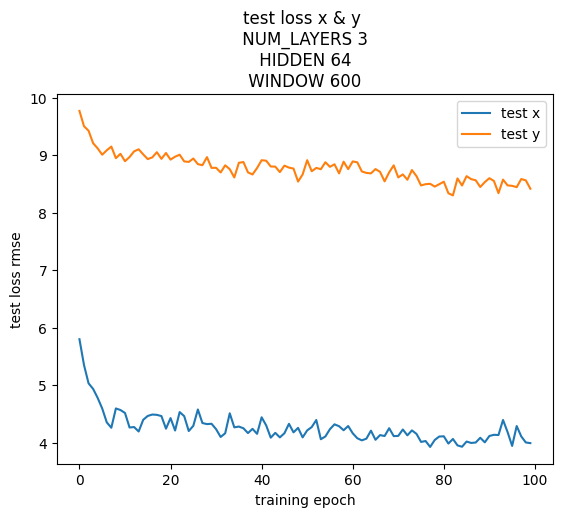

In [20]:
rmse_list_x=[]
rmse_list_y=[]

for epoch in range(EPOCHS):
    our_model.train()
    for inp, target in train_loader:
        pred = our_model(inp)
        l = loss(pred, target)
        optimizer.zero_grad()
        l.backward()
        optimizer.step()
    
    our_model.eval()
    errors = []
    with torch.no_grad():
        for inp, target in test_loader:
            pred = our_model(inp)
            errors.append((pred - target).numpy())
    errors = np.concatenate(errors)
    rmse_x = np.sqrt((errors[:, 0] ** 2).mean())
    rmse_y = np.sqrt((errors[:, 1] ** 2).mean())
    rmse_list_x.append(rmse_x)
    rmse_list_y.append(rmse_y)
    print(f"Epoch {epoch+1}: RMSE_x={rmse_x:.3f} μm, RMSE_y={rmse_y:.3f} μm")



fig=plt.figure()
ax=fig.add_subplot()
ax.plot(rmse_list_x,label="test x")
ax.plot(rmse_list_y,label="test y")
ax.legend()
ax.set_xlabel("training epoch")
ax.set_ylabel("test loss rmse")
ax.set_title(f"test loss x & y \n NUM_LAYERS {NUM_LAYERS} \n HIDDEN {HIDDEN} \n WINDOW {WINDOW} ")